In [101]:
import tensorflow as tf
from PIL import Image 
import numpy as np
import re
import os 
import glob 

In [102]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

In [180]:
class DataReader(object):
    def __init__(self, img_dir, mask_dir, is_training=True, img_size=(128, 128)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
        self.num_imgs = len(self.imgs_path)
        self.img_h, self.img_w = img_size
        self.is_training = is_training
    
    
    def find_mask(self, img_path):
        mask_path = re.sub(self.img_dir, self.mask_dir, img_path)
        mask_path = re.sub(".jpg", ".png", mask_path)
        return mask_path if os.path.exists(mask_path) else None
    
    
    def load_normalized_resize_img(self, img_path, is_mask=False, resize_method=tf.image.ResizeMethod.BILINEAR):
        img = tf.io.read_file(img_path)
        channels = 1 if is_mask else 3
        # tf.image.decode_image if passing dtype=tf.float32, the value is range from [0,1] no need to normalized again 
        img = tf.image.decode_image(img, channels=channels, dtype=tf.float32)
        img = tf.image.resize_with_pad(img, self.img_h, self.img_w, method=resize_method)
        return img
        
    
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        mask_path = self.find_mask(img_path)
        
        img = self.load_normalized_resize_img(img_path)
        if mask_path:
            mask = self.load_normalized_resize_img(mask_path, is_mask=True)
        else:
            mask = tf.zeros((self.img_h, self.img_w, 1), dtype=tf.float32)
        mask = tf.where(mask > 0, 1., 0)
        
        if self.is_training:
            img, mask = self.geo_transform(img, mask)
            img = self.color_transform(img)
            img = tf.clip_by_value(img, 0, 1)
        
        return img, mask 
    
    
    def iter(self):
        for i in range(self.num_imgs):
            yield self[i]
            
    
    def geo_transform(self, img, mask):
        random_number = random.random()
        if random_number < 0.2:
            img = tf.image.flip_left_right(img)
            mask = tf.image.flip_left_right(mask)
        elif random_number < 0.4:
            img = tf.image.flip_up_down(img)
            mask = tf.image.flip_up_down(mask)
        elif random_number < 0.6:
            img = tf.image.rot90(img, 1)
            mask = tf.image.rot90(mask, 1)
        elif random_number < 0.8:
            img = tf.image.rot90(img, 3)
            mask = tf.image.rot90(mask, 3)
        return img, mask 
    
    
    def color_transform(self, img):
        random_number = random.random()
        if random_number < 0.2:
            img = tf.image.adjust_gamma(img, 0.6)
        elif random_number < 0.6:
            img = tf.image.random_brightness(img, max_delta=0.1)
        return img

In [181]:
batch_size = 8
img_dir = "/app/seg/data/seg_training/images"
label_dir = "/app/seg/data/seg_training/labels"
data_reader = DataReader(img_dir, label_dir, is_training=True, img_size=(128, 128))
dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

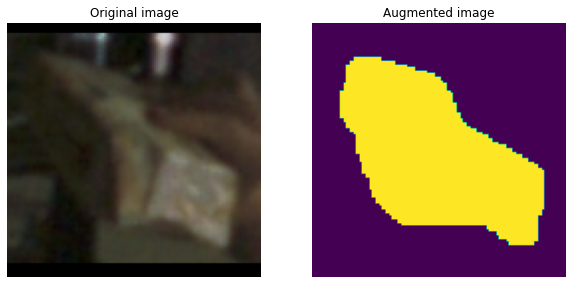

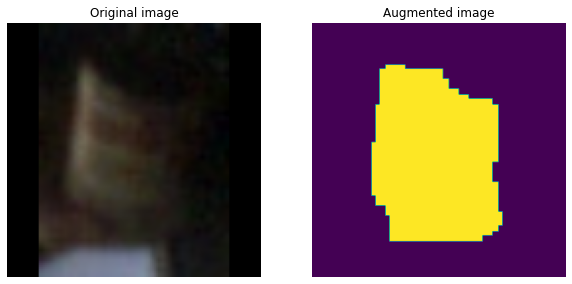

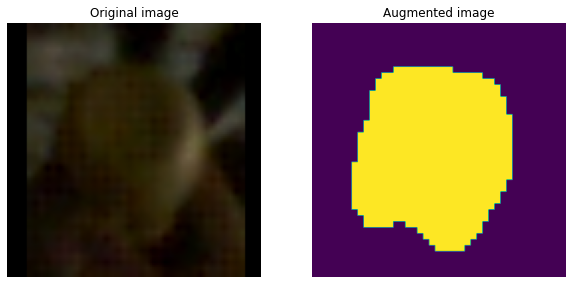

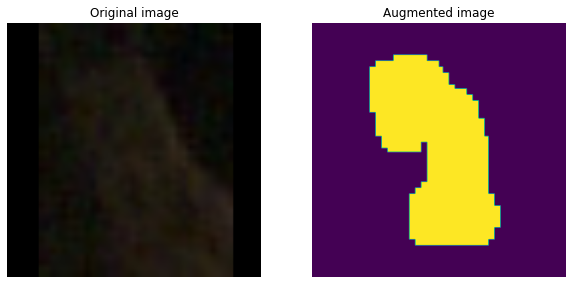

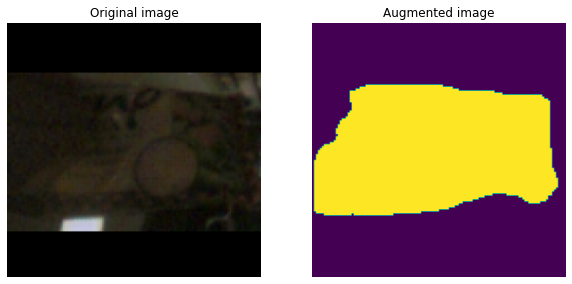

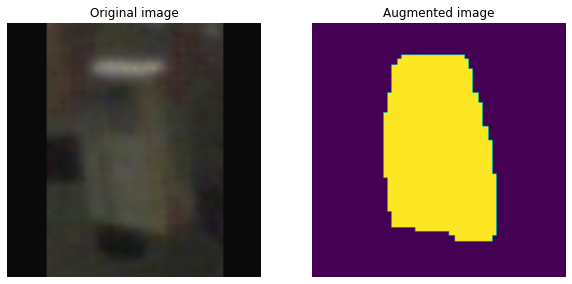

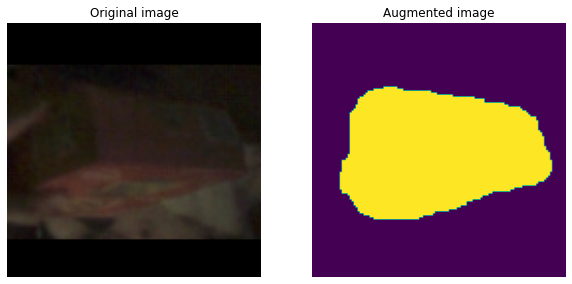

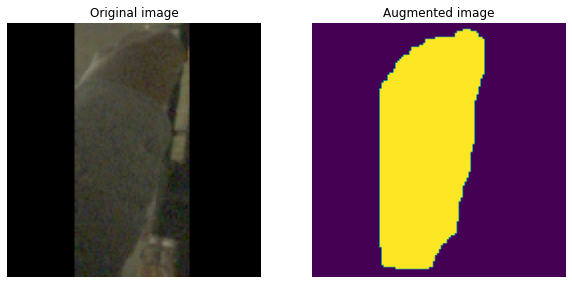

In [182]:
for imgs, masks in dataset:
    visualize(imgs[0], masks[0])
    visualize(imgs[1], masks[1])
    visualize(imgs[2], masks[2])
    visualize(imgs[3], masks[3])
    visualize(imgs[4], masks[4])
    visualize(imgs[5], masks[5])
    visualize(imgs[6], masks[6])
    visualize(imgs[7], masks[7])
    break
#     visualize(img, label)

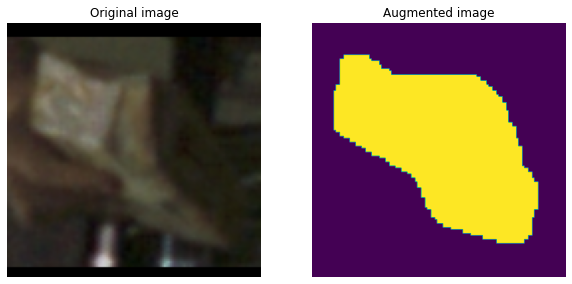

In [145]:
img, label = data_reader[0]
visualize(img, label)

In [28]:
unique = np.unique(img)
maximum = np.max(img)
print(maximum)
print(unique)


0.81523454
[0.0000000e+00 2.9435515e-04 3.0637256e-04 ... 8.0634201e-01 8.1072283e-01
 8.1523454e-01]


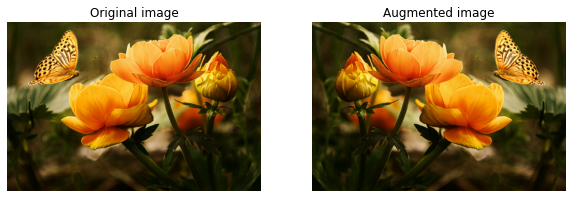

In [140]:
test_img = "/app/seg/data/pexels-pixabay-87452.jpg"
img = tf.io.read_file(test_img)
img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
aug = tf.image.flip_left_right(img)
visualize(img, aug)

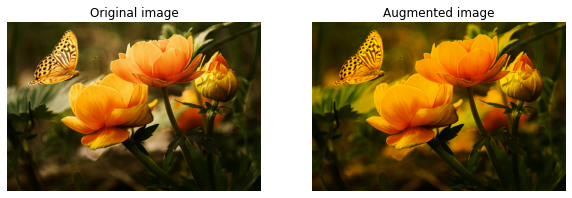

In [50]:
saturated = tf.image.adjust_saturation(img, 10)
visualize(img, saturated)

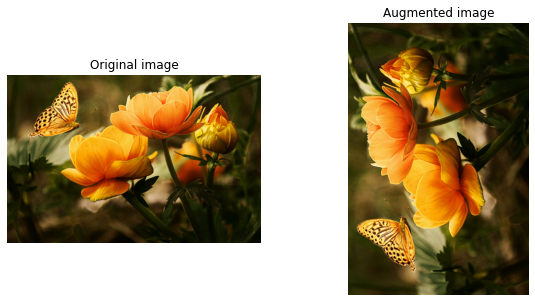

In [53]:
# counter clockwise
rotated = tf.image.rot90(img, 1)
visualize(img, rotated)

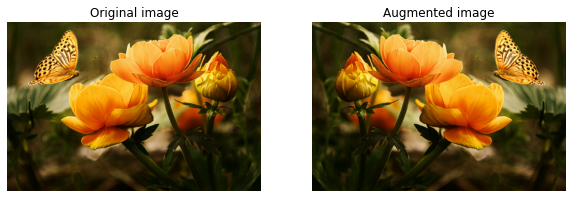

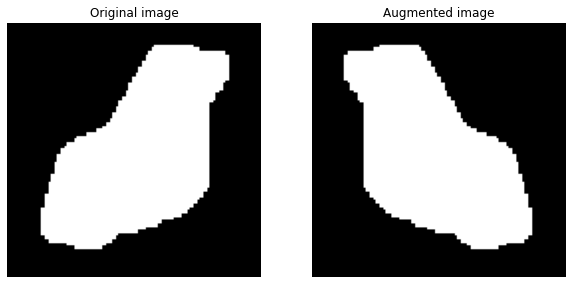

In [142]:
img, label
random_flip = tf.image.flip_left_right(img)
random_label = tf.image.flip_left_right(label)
visualize(img, random_flip)
visualize(label, random_label)

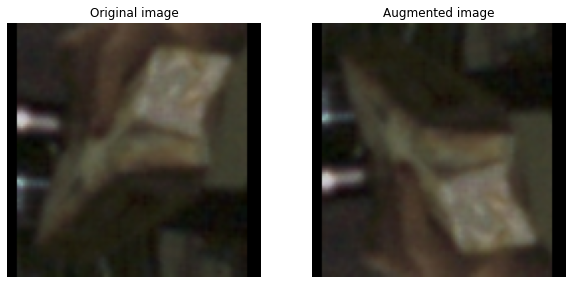

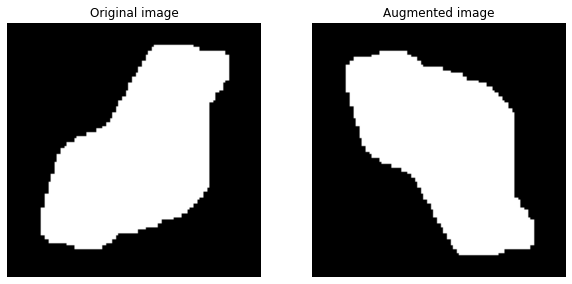

In [72]:
random_flip = tf.image.flip_up_down(img)
random_label = tf.image.flip_up_down(label)
visualize(img, random_flip)
visualize(label, random_label)

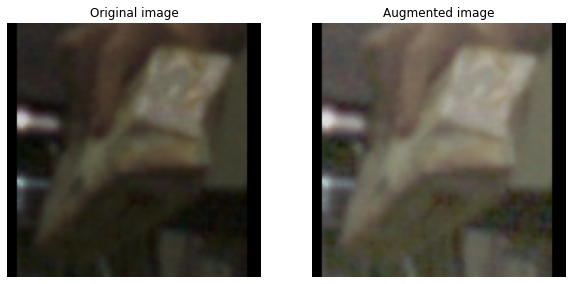

In [75]:
gamma = tf.image.adjust_gamma(img, 0.6)
visualize(img, gamma)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


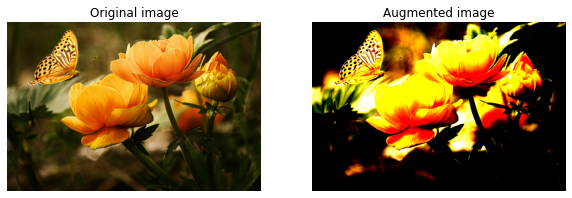

In [141]:
standardization = tf.image.per_image_standardization(img)
visualize(img, standardization)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


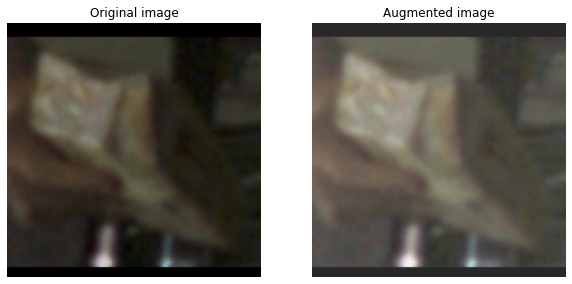

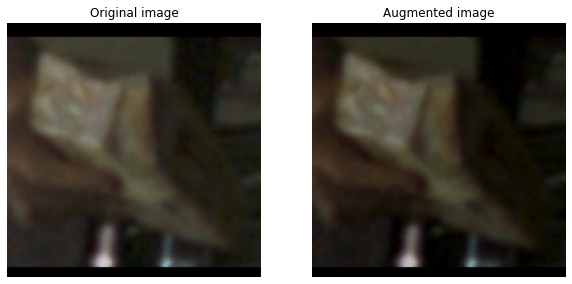

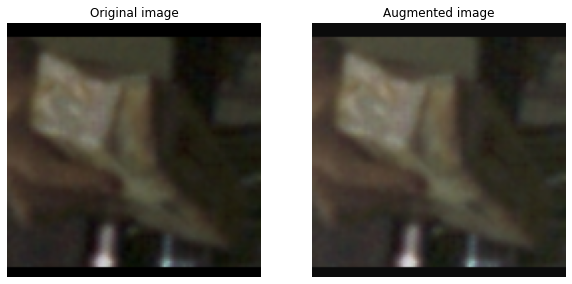

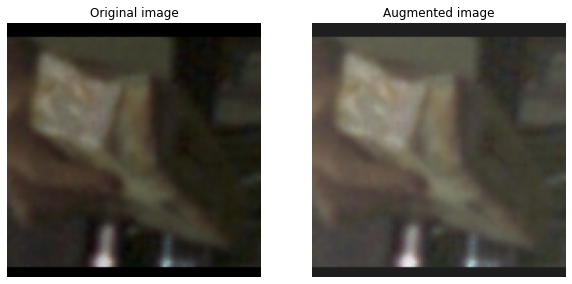

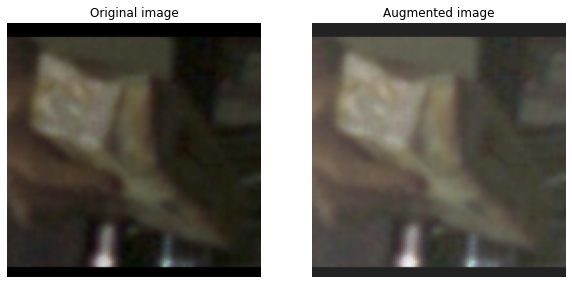

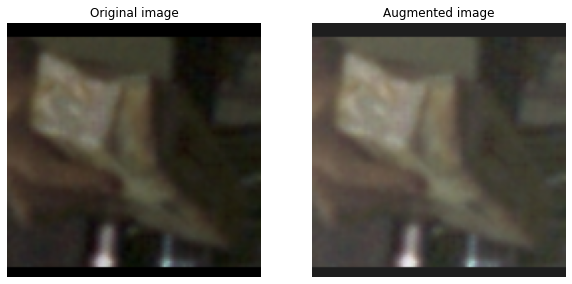

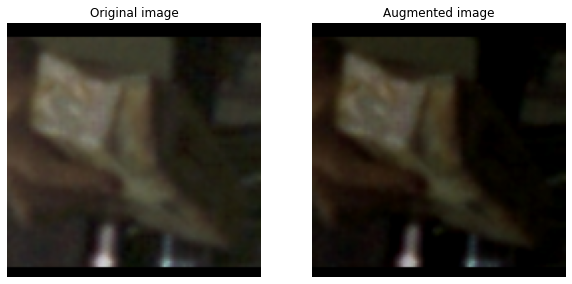

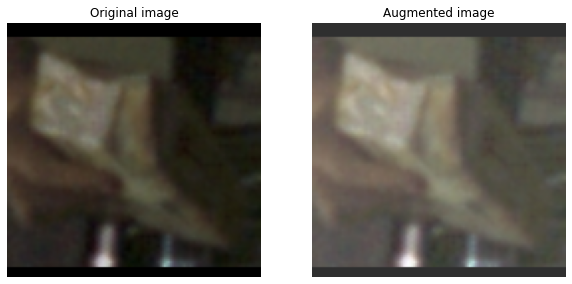

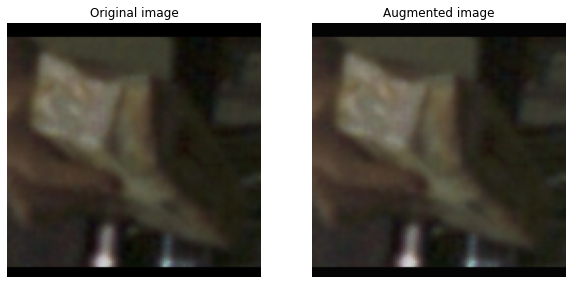

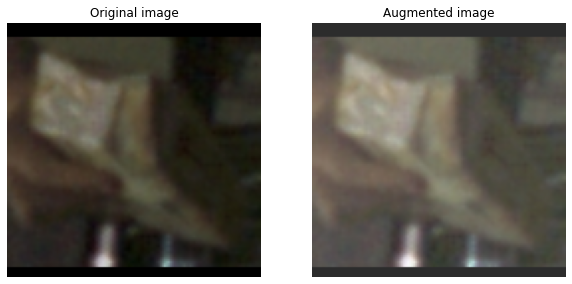

In [170]:
for i in range(10):
    img_adjust = tf.image.random_brightness(img, max_delta=0.2)
    visualize(img, img_adjust)